In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# read image
src = cv2.imread("fruits.jpg") # GBR
# B, G, R = cv2.split(src)
# cv2.namedWindow("Source")
# cv2.imshow("Source", B)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

from jupyterthemes import jtplot
jtplot.style(context="notebook", grid=False)

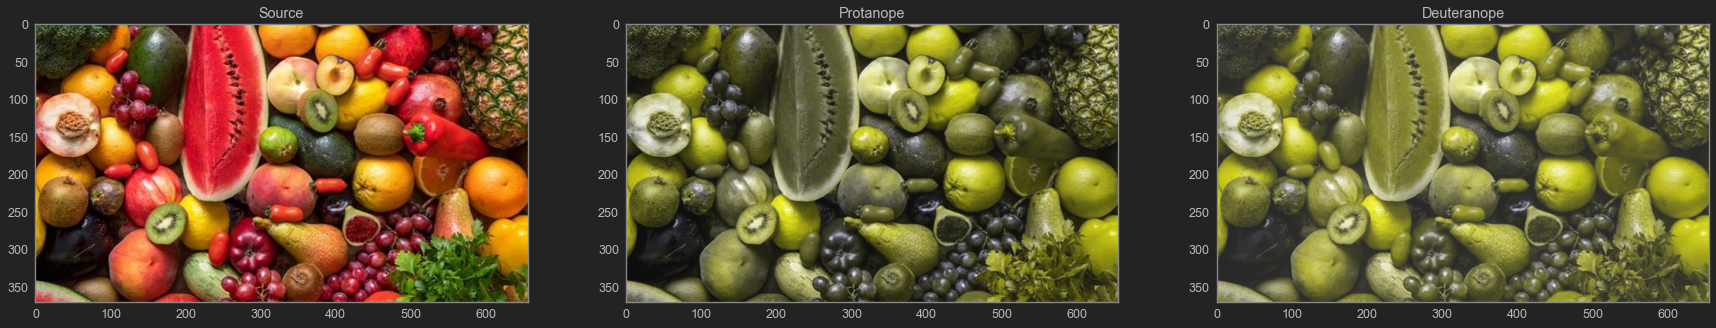

In [13]:
# sRGB --> Linear -> LMS and simulated
# with color domain reduction
lin_sr_P, lin_sg_P, lin_sb_P, lin_sr_D, lin_sg_D, lin_sb_D = srgb2linsrgb_inverse_gamma(src)
Lp, Mp, Sp = linsrgb2lms(lin_sr_P, lin_sg_P, lin_sb_P)
Ld, Md, Sd = linsrgb2lms(lin_sr_D, lin_sg_D, lin_sb_D)

# Protanope simulation
sim_Lp, sim_Mp, sim_Sp = P_simulation(Lp, Mp, Sp)
Psim_lin_sR, Psim_lin_sG, Psim_lin_sB  = lms2linsrgb(sim_Lp, sim_Mp, sim_Sp)
Psim_sR = linsrgb2srgb(Psim_lin_sR)
Psim_sG = linsrgb2srgb(Psim_lin_sG)
Psim_sB = linsrgb2srgb(Psim_lin_sB)

# Deuteranope simulation
sim_Ld, sim_Md, sim_Sd = D_simulation(Ld, Md, Sd)
Dsim_lin_sR, Dsim_lin_sG,Dsim_lin_sB  = lms2linsrgb(sim_Ld, sim_Md, sim_Sd)
Dsim_sR = linsrgb2srgb(Dsim_lin_sR)
Dsim_sG = linsrgb2srgb(Dsim_lin_sG)
Dsim_sB = linsrgb2srgb(Dsim_lin_sB)

# merge simulated
P_merged = cv2.merge([Psim_sB, Psim_sG, Psim_sR])
D_merged = cv2.merge([Dsim_sB, Dsim_sG, Dsim_sR])

# result show
plt.figure(figsize=(30,15))
plt.subplot(1,3,1)
plt.title('Source')
plt.imshow(src[:,:,::-1]) # opencv uses BGR format while matplotlib uses RGB format

plt.subplot(1,3,2)
plt.title('Protanope')
plt.imshow(P_merged[:,:,::-1])

plt.subplot(1,3,3)
plt.title('Deuteranope')
plt.imshow(D_merged[:,:,::-1])

plt.show()

In [12]:
"""
Reference:
1. https://stackoverflow.com/questions/57033168/how-to-convert-from-srgb-to-linear-srgb-for-computing-the-color-correction-matri
2. 老師修改的 colormath 功能
3. http://www.brucelindbloom.com/index.html?Eqn_RGB_XYZ_Matrix.html
4. http://entropymine.com/imageworsener/srgbformula/

Wt: D65
"""

def srgb2linsrgb_inverse_gamma(src_img):
    # sRGB color space --> linear sRgb color space
    """sRGB input should between [0, 1]"""
    srgb = src_img/255
    gamma = ((0.055+srgb)/1.055)**2.4
    scale = srgb/12.92
    lin_srgb = np.where(srgb<=0.04045, scale, gamma)
    
    # split to 3 channel
    lin_sr_split = cv2.split(lin_srgb)[2]
    lin_sg_split = cv2.split(lin_srgb)[1]
    lin_sb_split = cv2.split(lin_srgb)[0]
    
    # colour domain reduction (Viénot, F. et. al., 1999)
    lin_sr_P = 0.992052*lin_sr_split + 0.003974 # for protanope 
    lin_sg_P = 0.992052*lin_sg_split + 0.003974
    lin_sb_P = 0.992052*lin_sb_split + 0.003974
    
    lin_sr_D = 0.957237*lin_sr_split + 0.0213814 # for deuteranope
    lin_sg_D = 0.957237*lin_sg_split + 0.0213814
    lin_sb_D = 0.957237*lin_sb_split + 0.0213814
    
    return lin_sr_P, lin_sg_P, lin_sb_P, lin_sr_D, lin_sg_D, lin_sb_D

def linsrgb2lms(lin_sr, lin_sg, lin_sb): # XYZ color space --> LMS color space
    """
    M2lms = [[17.8824,43.5161,4.11935],
            [3.45565,27.1554,3.86714],
            [0.0299566,0.184309,1.46709]]
    (Viénot, F. et. al., 1999)
    """
    L = 17.8824*lin_sr + 43.5161*lin_sg + 4.11935*lin_sb
    M = 3.45565*lin_sr + 27.1554*lin_sg + 3.86714*lin_sb
    S = 0.0299566*lin_sr + 0.184309*lin_sg + 1.46709*lin_sb
    
    return L, M, S

"""
The simulated matrix is based on a research below :
Viénot, F., Brettel, H. and Mollon, J.D. (1999), 
Digital video colourmaps for checking the legibility of displays by dichromats. 
Color Res. Appl., 24: 243-252. 
https://0-doi.org.opac.lib.ntnu.edu.tw/10.1002/(SICI)1520-6378(199908)24:4<243::AID-COL5>3.0.CO;2-3
"""

# Simulated color for Protanope
def P_simulation(l,m,s):
    """
    M2P = [[0,2.02344,-2.52581],
            [0,1,0],
            [0,0,1]]
    """
    
    Lp = 0*l + 2.02344*m + -2.52581*s
    Mp = 0*l + 1*m + 0*s
    Sp = 0*l + 0*m + 1*s
    
    return Lp, Mp, Sp

# Simulated color for Deuteranope
def D_simulation(l,m,s):
    """
    M2D = [[1,0,0],
            [0.494207,0,1.24827],
            [0,0,1]]
   """ 
    Ld = 1*l + 0*m + 0*s
    Md = 0.494207*l + 0*m + 1.24827*s
    Sd = 0*l + 0*m + 1*s
    
    return Ld, Md, Sd

# LMS color space --> Linear color space
def lms2linsrgb(l,m,s):
    """
    M2linsrgb = [[0.080944,-0.130504,0.116721],
                [-0.0102485,-0.0540194,0.113615],
                [-0.000365294,-0.00412163,0.693513]]
    (Viénot, F. et. al., 1999)
    """
    sim_lin_sr = 0.080944*l + -0.130504*m + 0.116721*s
    sim_lin_sg = -0.0102485*l + 0.0540194*m + -0.113615*s
    sim_lin_sb = -0.000365294*l + -0.00412163*m + 0.693513*s
    
    # 處理爆掉的數字
    sim_lin_sr[sim_lin_sr<0] = 0
    sim_lin_sg[sim_lin_sg<0] = 0
    sim_lin_sb[sim_lin_sb<0] = 0
    sim_lin_sr[sim_lin_sr>1] = 1
    sim_lin_sg[sim_lin_sg>1] = 1
    sim_lin_sb[sim_lin_sb>1] = 1
    
    return sim_lin_sr, sim_lin_sg, sim_lin_sb

# Linear --> sRGB
def linsrgb2srgb(sim_lin):
    gamma = (1.055*(sim_lin**(1/2.4))-0.055)
    scale = sim_lin*12.92
    sim_srgb = np.where(sim_lin<=0.0031308, 255*scale, 255*gamma)
    sim_srgb = np.where(sim_srgb<0, 0, np.round(sim_srgb))
    sim_srgb = np.array(sim_srgb, dtype="uint8")
    
    return sim_srgb